# Reading and editing a topography
A topograph/bathymetry is needed to create the domain of interpolation (land-sea mask). The topography/bathymetry is usually extracted from a netCDF file.     
Adapted topographies:
* General Bathymetric Chart of the Oceans ([GEBCO](https://www.gebco.net/))
* [EMODnet Bathymetry](http://www.emodnet-bathymetry.eu)
* Other topographies can be used as long as they define the netCDF variables `lon`, `lat` and `bat` (positive above sea-level and negative below, in `DIVAnd` however, the convention is that `z` is positive in sea water).

This notebook illustrates how the land-sea mask can be modified, for example to exclude a lake.

In [1]:
using DIVAnd

┌ Info: Precompiling DIVAnd [efc8151c-67de-5a8f-9a35-d8f54746ae9d]
└ @ Base loading.jl:1187
┌ Warning: Deprecated syntax `multiple line breaks between doc string and object` at /home/ctroupin/.julia/packages/HTTP/mwR9J/src/Messages.jl:311.
│ Use `at most one line break` instead.
└ @ ~/.julia/packages/HTTP/mwR9J/src/Messages.jl:311
  likely near /home/ctroupin/.julia/dev/Mustache/src/utils.jl:23
┌ Warning: Loop variable `var` around /home/ctroupin/.julia/packages/DIVAnd/bRUC1/src/SDNMetadata.jl:562 overwrites a variable in an enclosing scope. In the future the variable will be local to the loop instead.
└ @ ~/.julia/packages/DIVAnd/bRUC1/src/SDNMetadata.jl:562


The full EMODnet Bathymetry is a quite big file (~1GB) that can be obtained from the bathymetry portal: http://portal.emodnet-bathymetry.eu/?menu=19. In the present notebook we will work with the GEBCO bathymetry with a resolution that has been decreased.

Note that an extremely fine bathymetry is not necessary when working on large domains.

## Data download and domain selection
We create a domain encompassing the north of Corsica.

In [2]:
dx = dy = 0.125
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6

# https://b2drop.eudat.eu/s/ACcxUEZZi6a4ziR/download  gebco_30sec_4.nc
# https://b2drop.eudat.eu/s/x83MSV8yUF934bL/download  gebco_30sec_8.nc
# https://b2drop.eudat.eu/s/o0vinoQutAC7eb0/download  gebco_30sec_16.nc

bathname = "gebco_30sec_8.nc"

if !isfile(bathname)
    @info("Download bathymetry")
    download("https://b2drop.eudat.eu/s/x83MSV8yUF934bL/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

bathisglobal = true;

┌ Info: Bathymetry file already downloaded
└ @ Main In[2]:15


We have two main tools to load the bathymetry:
1. `DIVAnd.extract_bath` loads the bathymetry at the resolution defined in the netCDF file while 
2. `DIVAnd.load_bath` reduces the resolution to match the resolution of the analysis.

### Extract bathymetry

In [3]:
?extract_bath

search: extract_bath



```
bx,by,b = DIVAnd.extract_bath(bath_name,isglobal,xi,yi)
```

Extract the bathymetry from the NetCDF file `bathname`. The parameter `isglobal`  is true if the NetCDF file covers the whole globe and thus the last longitude point can be considered to be right next to the first longitude point. `xi` and `yi` are vectors defining the bounding box of the data. No interpolation is performed.

**Convention:** b is positive in the water and negative in the air.


In [4]:
bx,by,b = extract_bath(bathname,true,lonr,latr)
@show size(b);

pcolor(bx,by,b'); colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

size(b) = (147, 39)


UndefVarError: UndefVarError: pcolor not defined

### Load bathymetry
With a change of its original resolution

In [5]:
?load_bath

search: load_bath



```
xi,yi,bath = DIVAnd.load_bath(bath_name,isglobal,xi,yi)
```

Load the bathymetry from the NetCDF file `bathname`. The parameter `isglobal` is true if the NetCDF file covers the whole globe and thus the last longitude point can be considered to be right next to the first longitude point. `xi` and `yi` are vectors containing the longitude and latitude grid onto which the bathymetry should be interpolated.


In [6]:
bx,by,b = load_bath(bathname,true,lonr,latr)

pcolor(bx,by,b'); 
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

#@show size(b)

UndefVarError: UndefVarError: pcolor not defined

## Mask creation
We start by defining the mask as a 3D matrix containing only `False`, then we set the values to `True` when the actual depth is deeper than the selected values stored in the vector `depthr`.

In [7]:
depthr = [0,10,20,500]
mask = falses(size(b,1),size(b,2),length(depthr))

for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end

Another solution is to use the `load_mask` function:

In [8]:
xmask,ymask,mmask = load_mask(bathname,true,lonr,latr,depthr);

In [13]:
using PyPlot
using Statistics

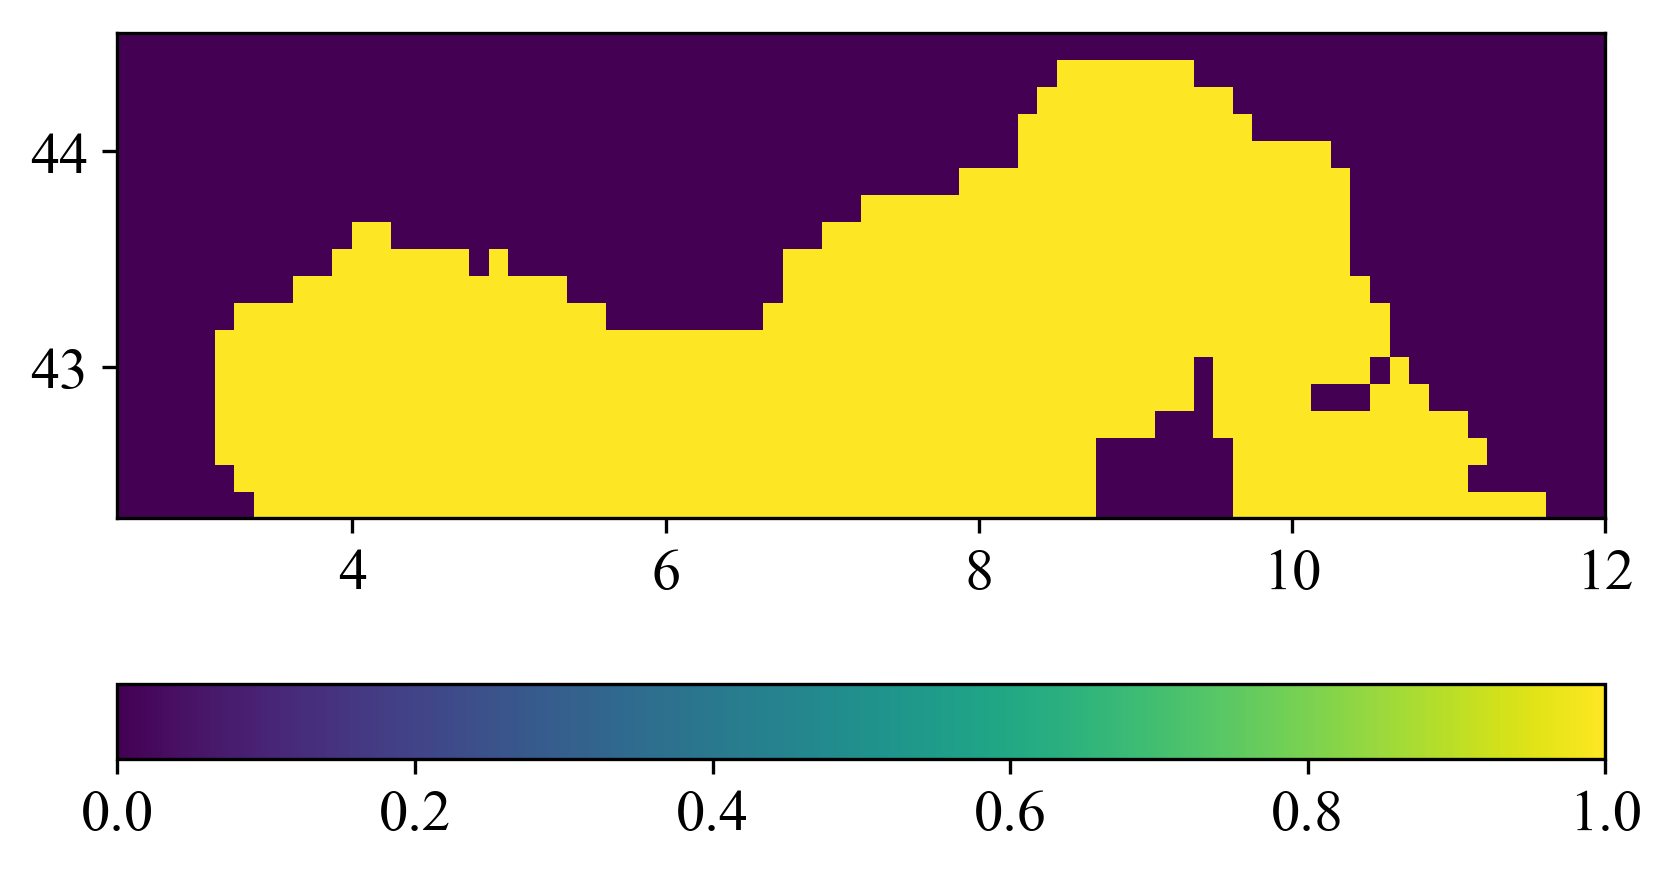

Add `using Statistics` to your imports.
  likely near /home/ctroupin/.julia/packages/IJulia/9RcVi/src/kernel.jl:32


In [14]:
pcolor(bx,by,Float64.(mask[:,:,1])'); 
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

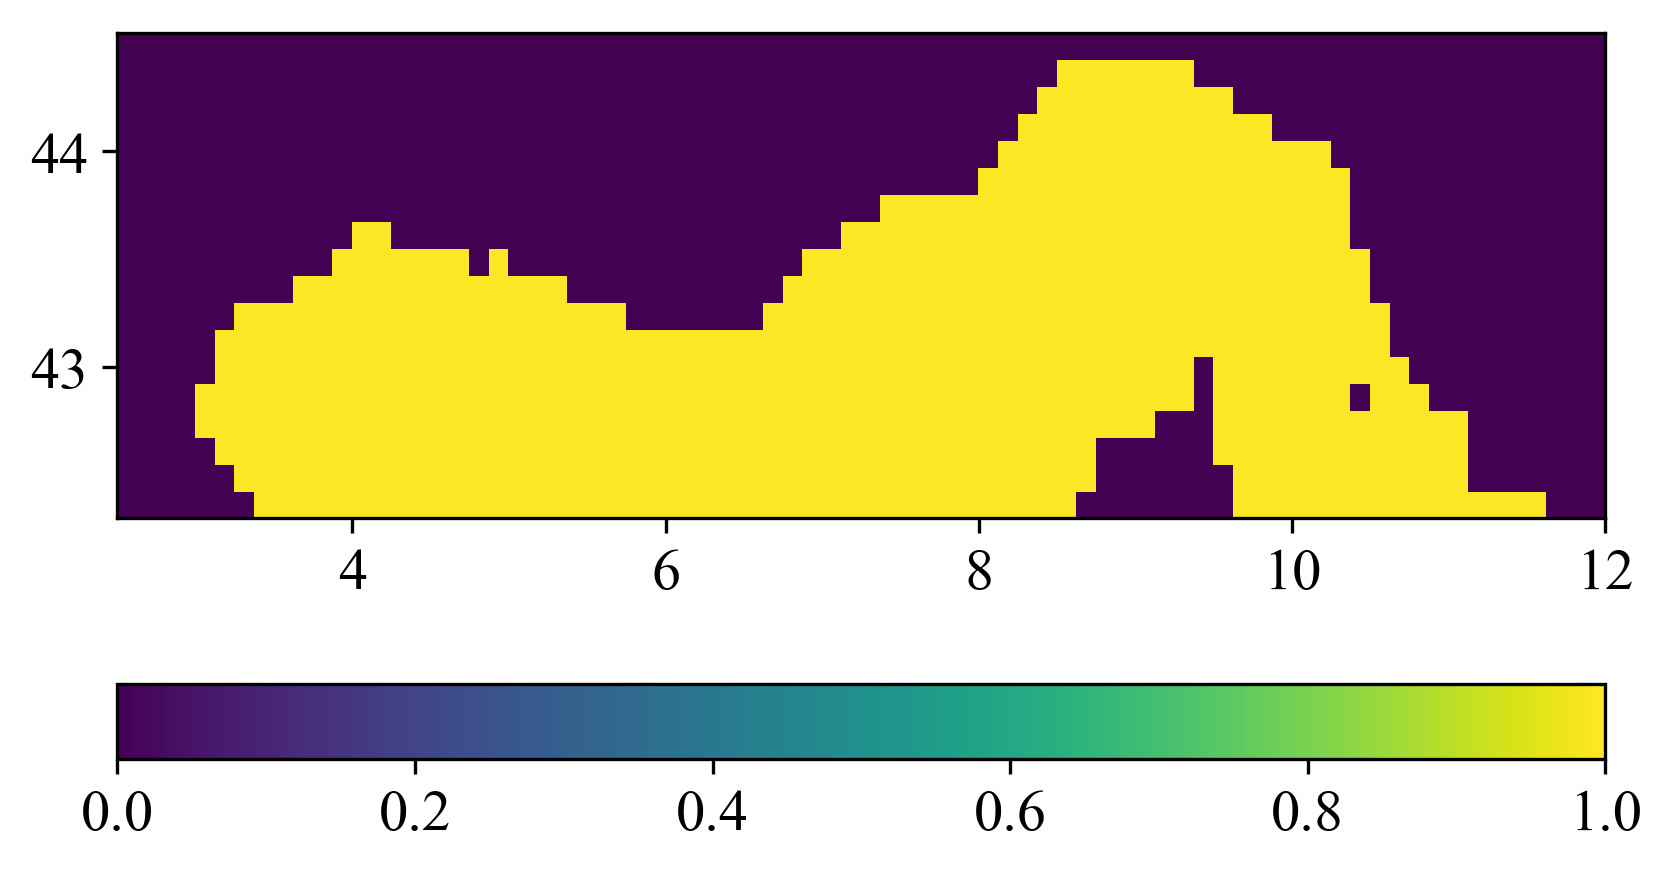

Add `using Statistics` to your imports.
  likely near /home/ctroupin/.julia/packages/IJulia/9RcVi/src/kernel.jl:32


In [15]:
pcolor(xmask,ymask,Float64.(mmask[:,:,1])'); 
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

## Mask editing
To edit the mask, you can either modify directly its value if you know the indices, or you can use a selection based on the coordinates.
### Create an artificial island
We simply modify the mask at a given location.

In [16]:
# Create a copy of the mask for ediding
mask_copy = copy(mask);
mask_copy[63,8,:] = false

┌ Warning: using `A[I...] = x` to implicitly broadcast `x` across many locations is deprecated. Use `A[I...] .= x` instead.
│   caller = top-level scope at In[16]:3
└ @ Core In[16]:3


false

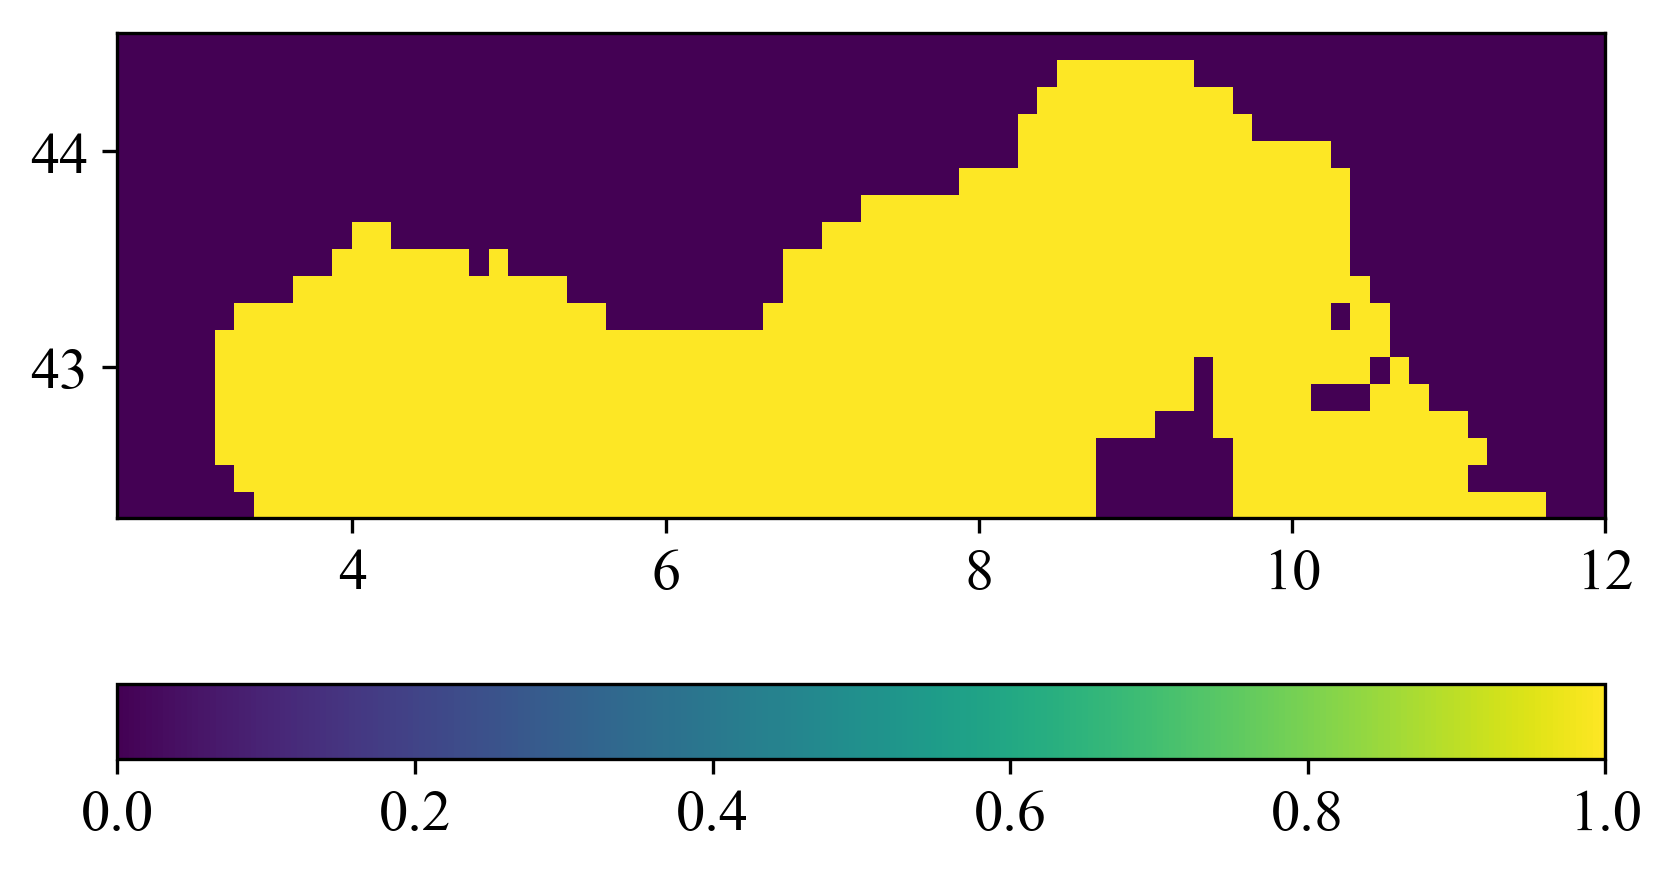

Add `using Statistics` to your imports.
  likely near /home/ctroupin/.julia/packages/IJulia/9RcVi/src/kernel.jl:32


In [17]:
pcolor(bx, by, Float64.(mask_copy[:,:,1])'); 
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

### Remove an island (based on indices)

In [20]:
mask_copy = copy(mask);
mask_copy[48:59,1:10,:] .= true;

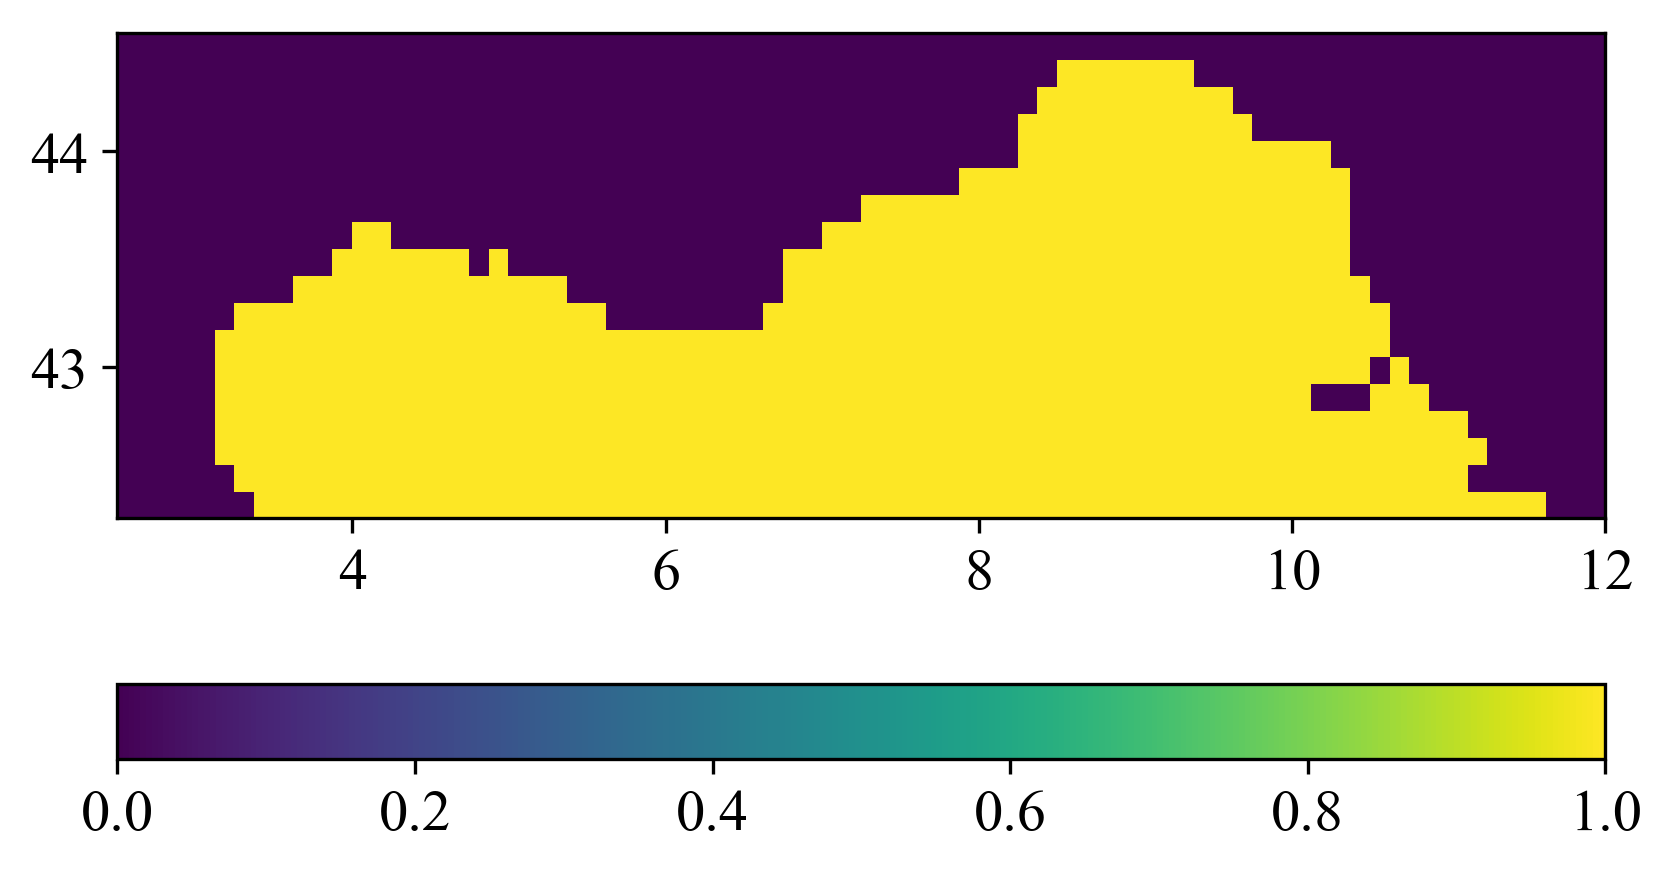

Add `using Statistics` to your imports.
  likely near /home/ctroupin/.julia/packages/IJulia/9RcVi/src/kernel.jl:32


In [21]:
pcolor(bx, by, Float64.(mask_copy[:,:,1])'); 
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

### Remove an island (based on coordinates). Recommended approach as you can change resolution easily
`sel_lon` and `sel_lat` are obtained by checking the longitude and latitudes.

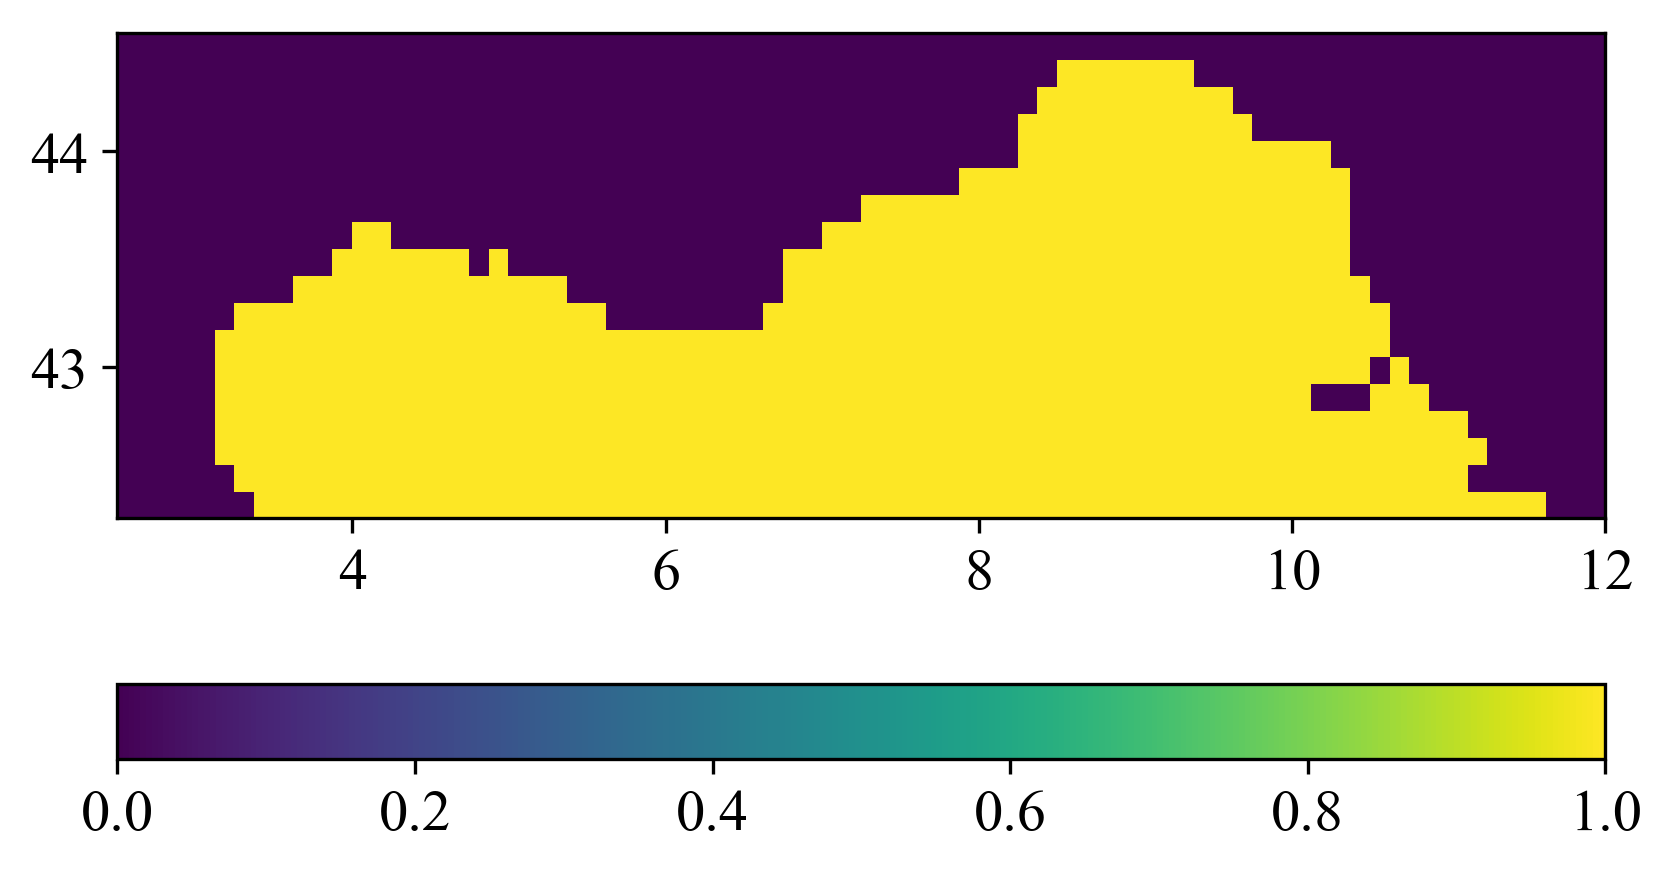

Add `using Statistics` to your imports.
  likely near /home/ctroupin/.julia/packages/IJulia/9RcVi/src/kernel.jl:32


In [23]:
mask_copy = copy(mask);
sel_lon = (bx.>8) .& (bx.<10.);
sel_lat = (by.<43.25);
mask_copy[sel_lon, sel_lat, :] .= true;
pcolor(bx, by, Float64.(mask_copy[:,:,1])'); 
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

In [25]:
@show sel_lon;

sel_lon = Bool[false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false]


## Exercice
1. Load the bathymetry around the Black Sea.
2. Create a land sea mask for the following levels: 0, 150, 500 and 1000 meters.
3. Remove the Sea of Azov and the Sea of Marmara.
4. Plot the result.

The solution is available in [06-topography-BlackSea](./solutions/06-topography-BlackSea) and should look like this:

<img src="./Images/BlackSea_mask.png" width="250px">